# Attack-CapsNet

Attack the capsule network trained on MNIST and CIFAR10 using adversarial examples.

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
import torch.nn.functional as F
import torchvision

from datasets import get_mnist_dataset, get_cifar10_dataset, get_data_loader
from utils import *
from attacks import *

from models import *

In [3]:
# class to extract probabilities from capsule network
# speeds up adversarial example generation
class CapsuleProbs(nn.Module):
    
    def __init__(self, caps_net):
        super().__init__()
        self.caps_net = caps_net

    def forward(self, x):
        d_caps = self.caps_net(x)
        logits = torch.norm(d_caps, dim=-1)
        return F.softmax(logits, 1)

## MNIST

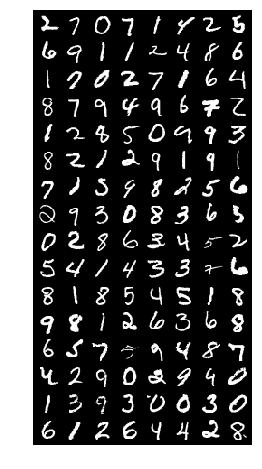

In [4]:
trainset, testset = get_mnist_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

6804224
8215568


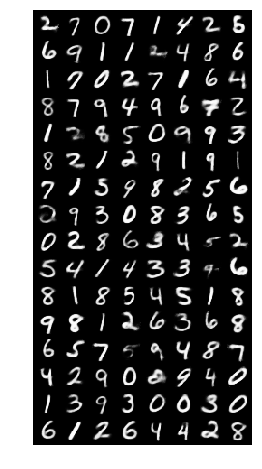

In [5]:
network = CapsuleNetwork().cuda()
decoder = CapsuleDecoder(reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.005)
caps_optimizer = optim.Adam(caps_model.parameters())
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True)
caps_trainer.load_checkpoint('weights/capsnet_mnist.pth.tar')
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch_hat.data)

In [6]:
def measure_robustness(model, batch, labels, indices, attack_args):
    adversary = Adversary(model)

    iter_counts = []
    seed_imgs = []
    fool_imgs = []
    seed_recs = []
    fool_recs = []
    seed_mses = []
    fool_mses = []
    
    for i in indices:
        seed_img = batch[i][None, ...]
        seed_label = labels[i]

        fool_img, iters = adversary.generate_example(seed_img.cuda(), ground=seed_label, **attack_args)
        results, reconstructions = evaluate_example(seed_img, fool_img, caps_model, reconstruction=True)

        if results['pred_fool'] != results['pred_seed']:
            iter_counts.append(iters)
            seed_imgs.append(seed_img)
            fool_imgs.append(fool_img)
            seed_recs.append(reconstructions['rec_seed'])
            fool_recs.append(reconstructions['rec_fool'])
            seed_mses.append(results['mse_seed'])
            fool_mses.append(results['mse_fool'])
    
    return {
        'iter_counts': iter_counts,
        'seed_imgs': seed_imgs,
        'fool_imgs': fool_imgs,
        'seed_recs': seed_recs,
        'fool_recs': fool_recs,
        'seed_mses': seed_mses,
        'fool_mses': fool_mses}

In [7]:
attack_args = {'attack': 'GA', 'eta': 0.5, 'n_iters': 150}
indices = list(range(len(batch)))
results_ga = measure_robustness(CapsuleProbs(network), batch, labels, indices, attack_args)

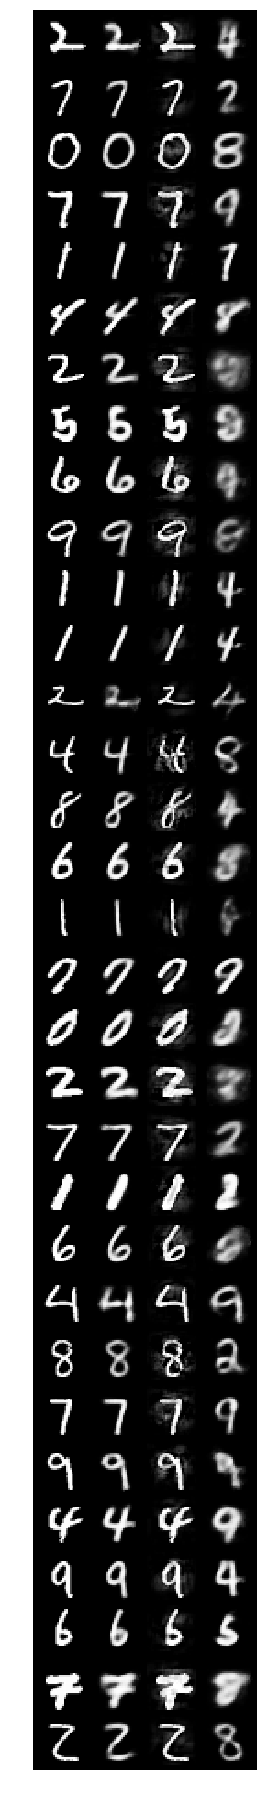

In [8]:
img_list = []
for x in zip(results_ga['seed_imgs'], results_ga['seed_recs'],
             results_ga['fool_imgs'], results_ga['fool_recs']):
    img_list.extend(list(x))

display_grid = torchvision.utils.make_grid(torch.cat(img_list[:32*4]), nrow=4)
plot_tensor(display_grid, fs=(4, 40))

In [9]:
attack_args = {'attack': 'GA', 'eta': 0.5, 'n_iters': 150}
indices = list(range(len(batch)))
results_fgs = measure_robustness(CapsuleProbs(network), batch, labels, indices, attack_args)

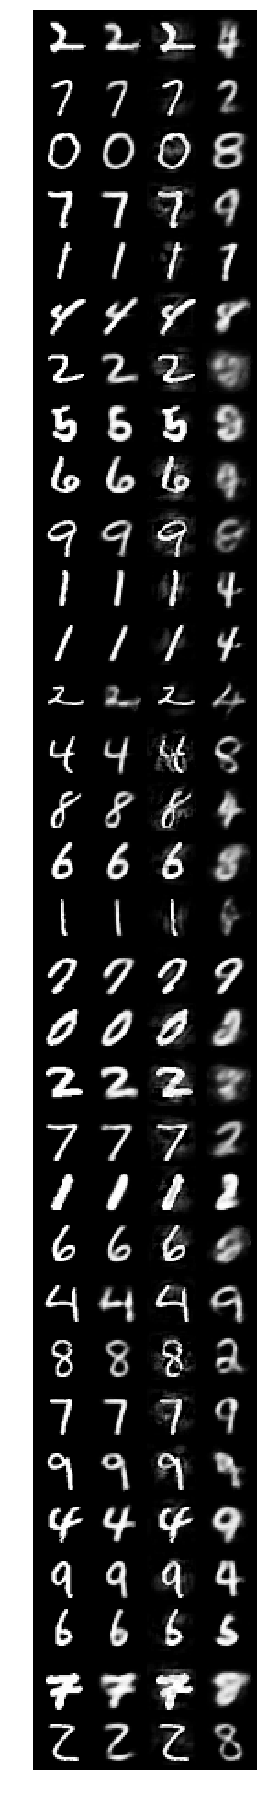

In [10]:
img_list = []
for x in zip(results_fgs['seed_imgs'], results_fgs['seed_recs'],
             results_fgs['fool_imgs'], results_fgs['fool_recs']):
    img_list.extend(list(x))

display_grid = torchvision.utils.make_grid(torch.cat(img_list[:32*4]), nrow=4)
plot_tensor(display_grid, fs=(4, 40))

In [21]:
def plot_roc(results):
    X1 = np.array(results['seed_mses'])
    X2 = np.array(results['fool_mses'])
    n = len(X1)
    
    tprs = []
    fprs = []
    for w in range(0, 80):
        tprs.append((X2 > w).mean())
        fprs.append((X1 > w).mean())
    
    plt.plot(fprs, tprs)

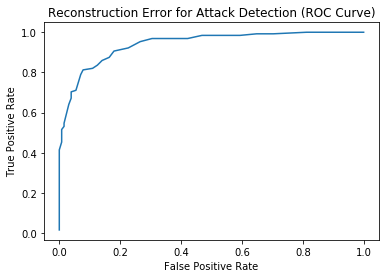

In [26]:
plt.title('Reconstruction Error for Attack Detection (ROC Curve)')
plot_roc(results_ga)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## CIFAR10

Files already downloaded and verified
Files already downloaded and verified


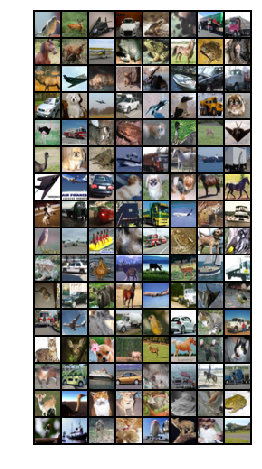

In [28]:
trainset, testset = get_cifar10_dataset()
trainloader, testloader = get_data_loader(trainset, testset)
batch, labels = next(iter(trainloader))
plot_batch(batch)
batch_var = Variable(batch.cuda())
labels_var = Variable(one_hotify(labels).cuda())

13628928
16647472


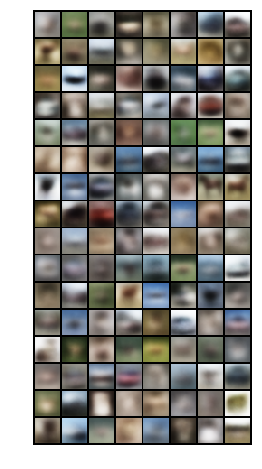

In [29]:
network = CapsuleNetwork(img_colors=3, p_caps=64).cuda()
decoder = CapsuleDecoder(img_colors=3, reconstruction=True, mask_incorrect=True).cuda()
caps_model = CapsuleModel(network, decoder)

print(count_params(network))
print(count_params(caps_model))

caps_loss = CapsuleLoss(rcsn_scale=0.001)
caps_optimizer = optim.Adam(caps_model.parameters(), lr=5e-3)
caps_trainer = Trainer(caps_model, caps_optimizer, caps_loss,
                       trainloader, testloader,
                       one_hot=True, use_reconstructions=True, use_cuda=True,
                       print_every=50)
caps_trainer.load_checkpoint('weights/capsnet_cifar.pth.tar')
probs, batch_hat = caps_model(batch_var, Variable(one_hotify(labels).cuda()))
plot_batch(batch_hat.data)

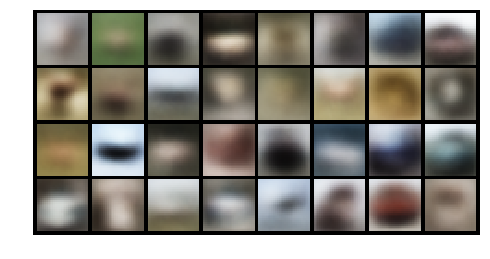

In [30]:
plot_batch(batch_hat[:32].data)

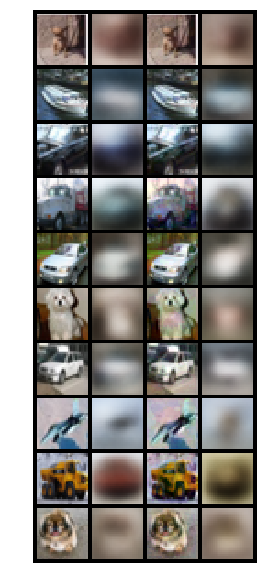

In [38]:
attack_args = {'attack': 'FGS', 'eta': 0.01, 'n_iters': 150}
indices = range(19, 32)
results = measure_robustness(CapsuleProbs(network), batch, labels, indices, attack_args)

img_list = []
for x in zip(results['seed_imgs'], results['seed_recs'],
             results['fool_imgs'], results['fool_recs']):
    img_list.extend(list(x))

display_grid = torchvision.utils.make_grid(torch.cat(img_list[:32*4]), nrow=4)
plot_tensor(display_grid, fs=(4, 40))

### References

[1] https://arxiv.org/abs/1710.09829